In [33]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from stfe.gene_utils import get_markers
import scanpy as sc
from plotly3d.plot import trajectories
from sklearn.cluster import KMeans
import pandas as pd
import pathlib
from sklearn.preprocessing import StandardScaler

In [34]:
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')
gene_names = adata.var_names.to_numpy()


In [35]:
traj = np.load(f"../results_final_Dec22/traj_gene_space_T.npy", allow_pickle=True)

# sc.pp.highly_variable_genes(adata, n_top_genes=400)
alex_genes = open('../data/alex_genes.txt').read().splitlines()
alex_tfs = open('../data/alex_tfs.txt').read().splitlines()

alex_gene_all = list(set(alex_genes) | set(alex_tfs))
alex_gene_all_mask = np.isin(adata.var_names, alex_gene_all)
traj = traj[:, :, alex_gene_all_mask]
gene_names = adata.var_names[alex_gene_all_mask]

In [36]:
traj_mean = traj.mean(axis=1)
traj_std = traj.std(axis=1)
traj_mean_std = traj_mean.std(axis=0)
zero_std_genes = traj_mean_std == 0
gene_names = np.array(gene_names)[~zero_std_genes]
traj, traj_mean, traj_std, traj_mean_std = traj[..., ~zero_std_genes], traj_mean[..., ~zero_std_genes], traj_std[..., ~zero_std_genes], traj_mean_std[..., ~zero_std_genes]
traj_mean_normalized = (traj_mean - traj_mean.mean(axis=0)) / traj_mean.std(axis=0)

In [37]:
trends_df = pd.DataFrame(traj_mean_normalized, columns=gene_names, index=[f't{i}' for i in range(traj_mean_normalized.shape[0])]).T


In [38]:
km = KMeans(random_state=42, n_clusters=5)
km.fit(trends_df)
cluster_labels = km.labels_
start_vals = [km.cluster_centers_[i][0] for i in range(km.n_clusters)]
sorted_indices = np.argsort(start_vals)[::-1]  # Sort indices in descending order
reorder_map = {old_label: new_label for new_label, old_label in enumerate(sorted_indices)}
reordered_labels = np.array([reorder_map[label] for label in cluster_labels])
cluster_labels = reordered_labels + 1

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(-2.5, 2.5)

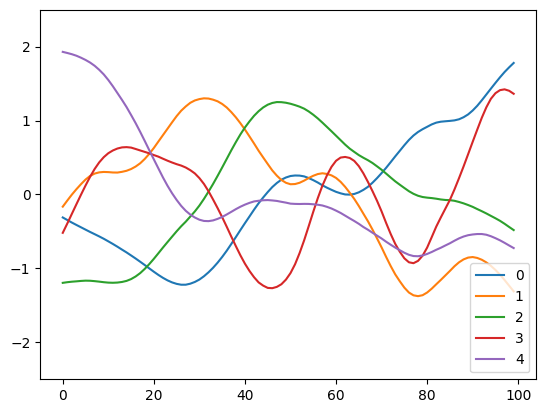

In [39]:
for i in range(len(np.unique(km.labels_))):
    plt.plot(km.cluster_centers_[i], label=i)
plt.legend()
plt.ylim(-2.5, 2.5)

In [40]:
results_dir = pathlib.Path('../results_final_Dec22/')
results_dir.mkdir(exist_ok=True)

np.random.seed(23)

# Sort the DataFrame by cluster labels
sorted_df = trends_df.iloc[np.argsort(cluster_labels)]
# sorted_row_colors = row_colors.iloc[np.argsort(cluster_labels)]
sorted_cluster_labels = cluster_labels[np.argsort(cluster_labels)]

# Save the data frames
sorted_df.to_csv(results_dir / f'sorted_df.csv')
# pd.DataFrame(sorted_row_colors).to_csv(results_dir / f'sorted_row_colors.csv')
pd.DataFrame({'cluster_labels': sorted_cluster_labels}, index=sorted_df.index).to_csv(results_dir / f'sorted_cluster_labels.csv')

cluster_df = pd.DataFrame({'cluster_labels': sorted_cluster_labels}, index=sorted_df.index)
gene_cluster_df = cluster_df.loc[alex_genes, :]
tf_cluster_df = cluster_df.loc[alex_tfs, :]
gene_cluster_df.to_csv(results_dir / f'gene_cluster_labels.csv')
tf_cluster_df.to_csv(results_dir / f'tf_cluster_labels.csv')

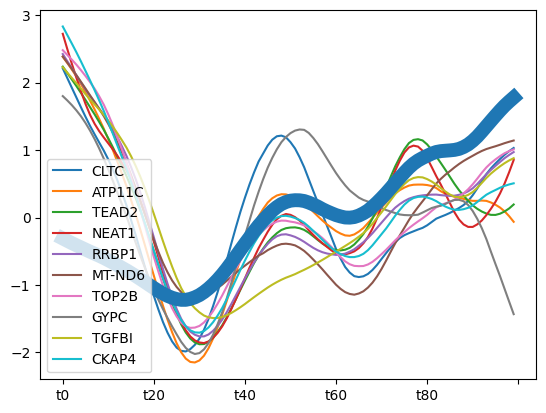

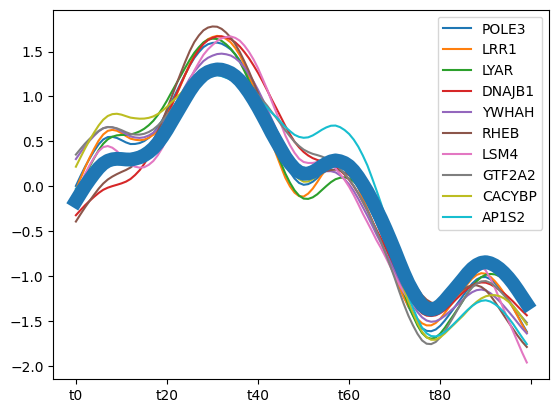

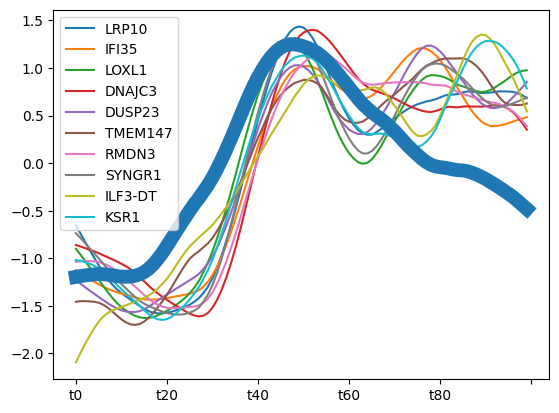

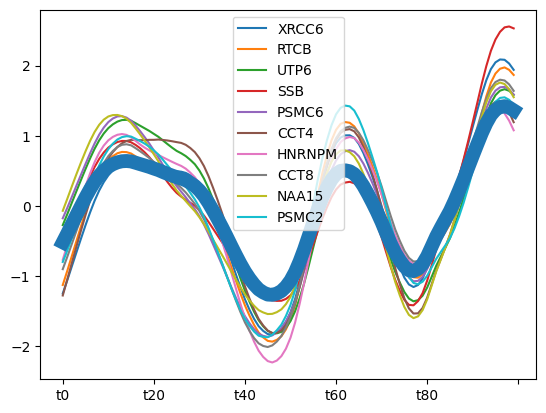

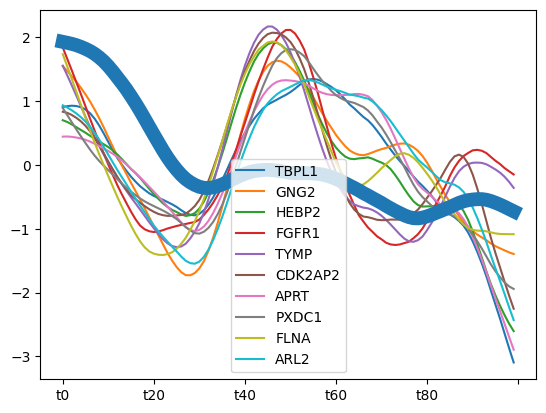

In [41]:
sorted_genes_per_cluster = {}
for cluster_label in np.unique(cluster_labels):
    genes1 = gene_cluster_df.loc[gene_cluster_df.cluster_labels == cluster_label, :].index.to_numpy()
    # Compute distances between each gene trend and the cluster center
    distances = np.linalg.norm(trends_df.loc[genes1, :].values - km.cluster_centers_[cluster_label - 1], axis=1)

    # Create DataFrame with gene names and distances, sort by distance
    distance_df = pd.DataFrame(
        {'distance': distances}, 
        index=genes1
    ).sort_values('distance')
    sorted_genes_per_cluster[cluster_label] = distance_df
    trends_df.loc[distance_df.iloc[:10].index, :].T.plot()
    plt.plot(km.cluster_centers_[cluster_label - 1], linewidth=10)


In [42]:
# Save each cluster's sorted genes to Excel
with pd.ExcelWriter(results_dir / 'sorted_genes_per_cluster.xlsx') as writer:
    for cluster_label, distance_df in sorted_genes_per_cluster.items():
        distance_df.to_excel(writer, sheet_name=f'Cluster_{cluster_label}')